<a href="https://colab.research.google.com/github/sahar7888/NLP_LLM_Projects/blob/main/NLP_Fine_tuning_Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

In [3]:
#Packages
#%% packages
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import AutoModel, DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
yelp = load_dataset('yelp_review_full')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
yelp

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

# EDA

In [6]:
#%% create dataset
train_ds = yelp['train']
train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [7]:
train_ds.features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [8]:
# %% imbalance of dataset
val_count = pd.DataFrame(train_ds['label']).value_counts()

<Axes: ylabel='count'>

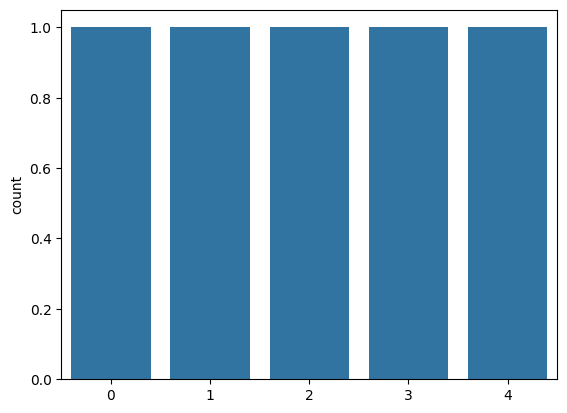

In [9]:
sns.countplot(val_count.tolist())

In [10]:
#%% create dataset
train_ds = yelp['train'].select(range(1000))

<Axes: xlabel='label', ylabel='review_length'>

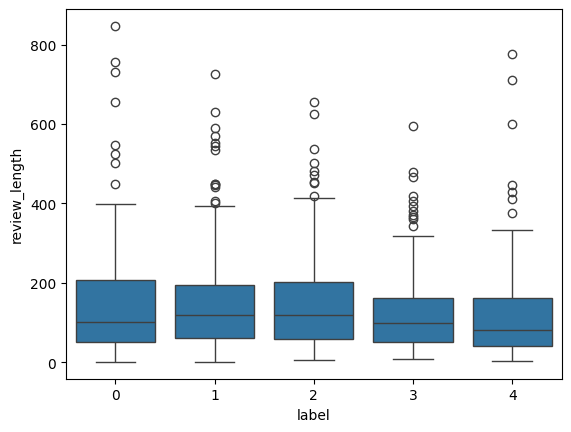

In [11]:
# %% understanding the texts
# count of words per review / per class
df_review_len_label = pd.DataFrame({'review_length': [len(s.split()) for s in train_ds['text']], 'label': train_ds['label']})
sns.boxplot(x='label', y='review_length', data=df_review_len_label)

In [12]:
#%% Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cpu'

In [13]:
model = AutoModel.from_pretrained(model_name).to(device)

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [15]:
#Ex:
# %% Tokenizer
text = 'Hello, this is a sample sentence!'

encoded_text = tokenizer(text, return_tensors='pt')
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 7099, 6251,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [16]:
# %% Tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'][0])
tokens

['[CLS]', 'hello', ',', 'this', 'is', 'a', 'sample', 'sentence', '!', '[SEP]']

In [17]:
# %%
tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a sample sentence ! [SEP]'

In [18]:
# %% how large is the vocabulary?
tokenizer.vocab_size

30522

In [19]:
# %% Max context length
max_context_length = tokenizer.model_max_length
max_context_length

512

In [20]:
# %% Function for tokenization
def tokenize_text(batch):
  # padding...texts are filled with zeros based to longest example
    # truncation...texts are cut off after max_context_length
    return tokenizer(batch['text'], padding='max_length', truncation=True)


In [21]:
yelp_encodings = train_ds.map(tokenize_text, batched=True, batch_size=128)

In [22]:
yelp_encodings.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])  # encodings need to be converted to torch tensors

In [23]:
def get_last_hidden_state(batch):
    inputs = {k: v for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # [:, 0] refers to CLS token for complete sentence representation
    return {'hidden_state': last_hidden_state[:, 0]}

In [24]:
yelp_hidden_states = yelp_encodings.map(get_last_hidden_state, batched=True, batch_size=128)  # will have additional column 'hidden_state

In [25]:
yelp_hidden_states

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1000
})

In [26]:
import joblib
joblib.dump(yelp_hidden_states, 'yelp_hidden_states.joblib')

['yelp_hidden_states.joblib']

In [27]:
cutoff = 800
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff: ])
y_test = np.array(yelp_hidden_states['label'][cutoff: ])
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (800, 768), y_train.shape: (800,)
X_test.shape: (200, 768), y_test.shape: (200,)


In [28]:

# %% SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.395

In [29]:
# %% Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.425

In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)
# %%

0.33

In [31]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.165

# Fine Tunning a new model

In [32]:
#%% packages
from transformers import AutoModelForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import DatasetDict

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
# %% YELP Dataset

In [33]:
#%%  dataset
yelp_hidden_states = joblib.load('yelp_hidden_states.joblib')


In [34]:
#%% Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cuda'
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#%% Dataset
train_ds = yelp_hidden_states.select(range(0, 800))
eval_ds = yelp_hidden_states.select(range(800, 1000))
print(train_ds[0]['input_ids'].shape)
print(eval_ds[0]['input_ids'].shape)
print(yelp_hidden_states[800]['input_ids'].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])


In [36]:
#%% DatasetDict
yelp_ds_dict = DatasetDict({'train': train_ds, 'test':eval_ds})

In [36]:
!pip install accelerate

In [37]:
!pip install accelerate --upgrade

  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [38]:
!pip show accelerate

Name: accelerate
Version: 0.30.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [37]:
import accelerate


In [40]:
!pip uninstall accelerate Y


Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-estimate-memory
    /usr/local/bin/accelerate-launch
    /usr/local/lib/python3.10/dist-packages/accelerate-0.30.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/accelerate/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 680, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 375, in remove
    if auto_confirm o

In [41]:
!apt-get uninstall -y accelerate



E: Invalid operation uninstall


In [38]:
!pip install accelerate==0.21.0

In [39]:
#%% Trainer Arguments
batch_size = 8  # adapt BS to fit into memory
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    learning_rate=2e-5,              # learning rate
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy='epoch',
    log_level='error',
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs

)

In [40]:
!pip install transformers --upgrade

In [45]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1


In [45]:
from accelerate import Accelerator
accelerator = Accelerator()

In [46]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=yelp_ds_dict['train'], eval_dataset=yelp_ds_dict['test'])

TypeError: Accelerator.__init__() got an unexpected keyword argument 'use_seedable_sampler'

In [ ]:
# %% get losses
trainer.evaluate()

# %% calculate predictions
preds = trainer.predict(yelp_ds_dict['test'])

# %%
preds.metrics
# %%
np.argmax(preds.predictions, axis=1)

In [ ]:
# %% confusion matrix
true_classes = yelp_ds_dict['test']['label']
preds_classes = np.argmax(preds.predictions, axis=1)
conf_mat = confusion_matrix(true_classes, preds_classes)
sns.heatmap(conf_mat, annot=True)
# %% accuracy
accuracy_score(true_classes, preds_classes)

In [47]:
# %% baseline classifier training

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(yelp_ds_dict['train']['label'], yelp_ds_dict['train']['label'])

DummyClassifier(strategy='most_frequent')

In [48]:
# %% baseline classifier accuracy
dummy_clf.score(yelp_ds_dict['test']['label'], yelp_ds_dict['test']['label'])

0.165

In [49]:
# %% inspect individual reviews
model_cpu = model.to('cpu')

In [50]:
#%% Inference
with torch.no_grad():
    outputs = model_cpu(yelp_ds_dict['test']['input_ids'], yelp_ds_dict['test']['attention_mask'])
#%% Loss calculation
pred_labels = torch.argmax(outputs.logits, dim=1)
loss = cross_entropy(outputs.logits, yelp_ds_dict['test']['label'], reduction='none')

# %%
df_individual_reviews = pd.DataFrame({'text': yelp_ds_dict['test']['text'], 'label': yelp_ds_dict['test']['label'], 'pred_label': pred_labels, 'loss': loss}).sort_values('loss', ascending=False).reset_index(drop=True)
# %%
df_individual_reviews

,text,label,pred_label,loss
0,"Ugh... I got a plate with seisage, tofu scramb...",0,2,1.773554
1,This place is looking to make money and rip yo...,0,2,1.766537
2,My partner and I were visiting my family in Pi...,0,2,1.765961
3,I've eaten here once after having it suggested...,0,2,1.757589
4,For our last lunch in Pittsburgh we decided to...,0,2,1.756704
...,...,...,...,...
195,I finally went to Casbah for brunch today. Rol...,2,2,1.509061
196,I don't think I would have known about Quiet S...,2,2,1.501413
197,My experience has been ok at the Quiet Storm b...,2,2,1.499187
198,"Food is tasty, though portions are for the wai...",2,2,1.492034
